In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
import optuna

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py


In [2]:
#把數據庫放進train裡面
train = pd.read_csv('/kaggle/input/jane-street-market-prediction/train.csv', nrows=2000000)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 2.1 GB


In [3]:
#把weight=0的部分刪掉
train = train[train['weight']!=0]

# 創建action
# 因為resp是用來當分類器所以把resp定義成action
# 為了把resp的效用最大化所以要最大化pi，pi=∑j(weightij∗respij∗actionij)
# resp會增加pi
train['action'] = train['resp'].apply(lambda x:x>0).astype(int)

In [4]:
features = [col for col in list(train.columns) if 'feature' in col]

In [5]:
X = train[features]
y = train['action']

# 保留部分train的數據當作保留驗證集
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2)

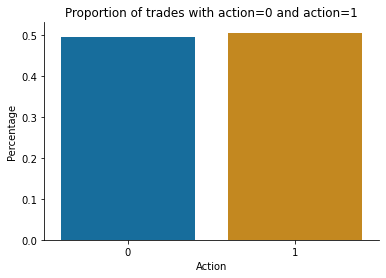

In [6]:
# 先檢查目標數據在訓練數據內有沒有平衡
sns.set_palette("colorblind")
ax = sns.barplot(train_y.value_counts().index, train_y.value_counts()/len(train_y))
ax.set_title("Proportion of trades with action=0 and action=1")
ax.set_ylabel("Percentage")
ax.set_xlabel("Action")
sns.despine();
# 目標數據相當均衡，幾乎每個action的對應交易都占50％

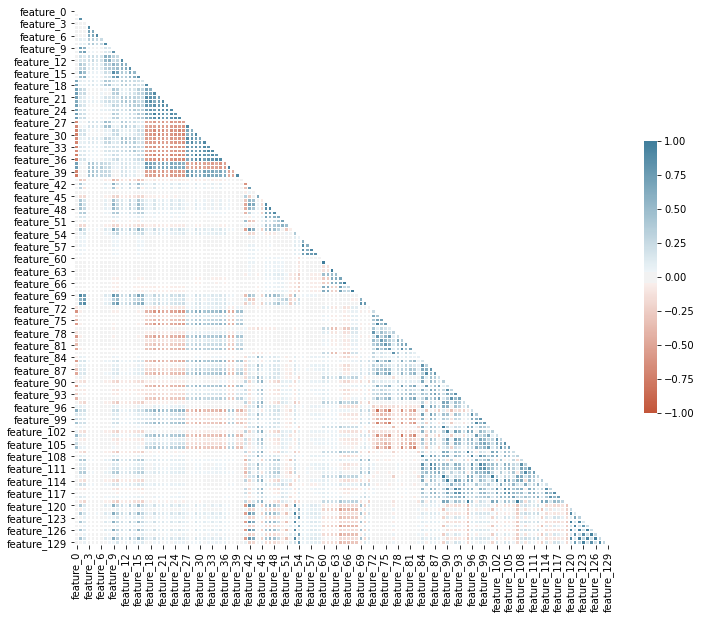

In [7]:
# 繪製對角線相關圖，用來查看各個特徵的關聯性
corr = train_x.corr()


mask = np.triu(np.ones_like(corr, dtype=bool))


f, ax = plt.subplots(figsize=(12, 10))


cmap = sns.diverging_palette(20, 230, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
# 有幾個feature有強烈的關聯性

In [8]:
# 調查feature的缺失值且進行估算
missing_values = pd.DataFrame()
missing_values['feature'] = features
missing_values['num_missing'] = [train_x[i].isna().sum() for i in features]
missing_values.T

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
feature,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129
num_missing,0,0,0,327,327,0,0,210401,210401,409,...,36444,36444,116,116,8217,8217,4553,4553,989,989


In [9]:
train_median = train_x.median()
# 在訓練集和保留驗證集中估算中位數
train_x = train_x.fillna(train_median)
valid_x = valid_x.fillna(train_median)

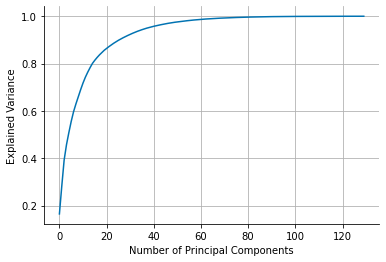

In [10]:
# 要進行PCA前要先把所有feature內的資料標準化
scaler = StandardScaler()
scaler.fit(train_x)
train_x_norm = scaler.transform(train_x)

pca = PCA()
comp = pca.fit(train_x_norm)

# 繪製圖表顯示129個feature的變化如何隨feature的數量而變化
# 前15個feature包括了大約80％的變化
# 前40個feature包括大約95％的變化


plt.plot(np.cumsum(comp.explained_variance_ratio_))
plt.grid()
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
sns.despine();

In [11]:
# 只使用前50個feature來使用PCA而不使用所有feature來提高速度
pca = PCA(n_components=50).fit(train_x_norm)
train_x_transform = pca.transform(train_x_norm)

In [12]:
#轉換驗證集
valid_x_transform = pca.transform(scaler.transform(valid_x))

In [13]:
dtrain = xgb.DMatrix(train_x_transform, label=train_y)
dvalid = xgb.DMatrix(valid_x_transform, label=valid_y)

In [14]:
def objective(trial):
    
# 設定xgboost的參數
# params設定xgboost要調整的參數範圍
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'max_depth': trial.suggest_int('max_depth', 10, 25),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.50, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 1),
        'gamma': trial.suggest_int('gamma', 0, 10),
        'tree_method': 'gpu_hist',  
        'objective': 'binary:logistic'
    }
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
# 根據測試集的準確性評估並測試
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy

In [15]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=25, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-01-09 20:55:58,071] A new study created in memory with name: no-name-4227df9b-eee5-437e-8949-11eb85bba853


[20:55:58] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 20:56:52,438] Trial 0 finished with value: 0.5231281339242947 and parameters: {'n_estimators': 333, 'max_depth': 23, 'learning_rate': 0.0855625012946475, 'subsample': 0.6535460302765139, 'colsample_bytree': 0.7962467862825195, 'gamma': 0}. Best is trial 0 with value: 0.5231281339242947.


[20:56:52] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 20:56:54,551] Trial 1 finished with value: 0.5290337054126321 and parameters: {'n_estimators': 386, 'max_depth': 12, 'learning_rate': 0.028257377346312437, 'subsample': 0.9883168815113867, 'colsample_bytree': 0.9307568802462851, 'gamma': 6}. Best is trial 1 with value: 0.5290337054126321.


[20:56:54] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 20:57:13,137] Trial 2 finished with value: 0.5295066361889055 and parameters: {'n_estimators': 248, 'max_depth': 17, 'learning_rate': 0.0732195050254153, 'subsample': 0.9909274450431939, 'colsample_bytree': 0.8712407063085166, 'gamma': 0}. Best is trial 2 with value: 0.5295066361889055.


[20:57:13] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 20:58:02,609] Trial 3 finished with value: 0.5278240940040866 and parameters: {'n_estimators': 510, 'max_depth': 22, 'learning_rate': 0.020838761176615796, 'subsample': 0.7763870013677094, 'colsample_bytree': 0.9708643533339509, 'gamma': 1}. Best is trial 2 with value: 0.5295066361889055.


[20:58:02] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 20:58:05,131] Trial 4 finished with value: 0.5269297697797234 and parameters: {'n_estimators': 239, 'max_depth': 12, 'learning_rate': 0.06337105170699513, 'subsample': 0.6486068348904444, 'colsample_bytree': 0.7425363946756668, 'gamma': 2}. Best is trial 2 with value: 0.5295066361889055.


[20:58:05] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 20:58:12,196] Trial 5 finished with value: 0.5293611190269752 and parameters: {'n_estimators': 564, 'max_depth': 15, 'learning_rate': 0.039663568624825035, 'subsample': 0.8363679183273007, 'colsample_bytree': 0.7314521656684974, 'gamma': 3}. Best is trial 2 with value: 0.5295066361889055.


[20:58:12] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 20:59:17,371] Trial 6 finished with value: 0.5246772853773441 and parameters: {'n_estimators': 228, 'max_depth': 24, 'learning_rate': 0.03161849044157907, 'subsample': 0.7404402109467793, 'colsample_bytree': 0.7564561163786698, 'gamma': 0}. Best is trial 2 with value: 0.5295066361889055.


[20:59:17] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 20:59:18,403] Trial 7 finished with value: 0.5251077736480546 and parameters: {'n_estimators': 313, 'max_depth': 12, 'learning_rate': 0.02619368113441485, 'subsample': 0.5112407257234411, 'colsample_bytree': 0.5639833569796711, 'gamma': 9}. Best is trial 2 with value: 0.5295066361889055.


[20:59:18] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 20:59:19,482] Trial 8 finished with value: 0.5277149561326389 and parameters: {'n_estimators': 265, 'max_depth': 12, 'learning_rate': 0.0630975250584577, 'subsample': 0.6474191001195302, 'colsample_bytree': 0.6797969004614448, 'gamma': 10}. Best is trial 2 with value: 0.5295066361889055.


[20:59:19] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 20:59:27,053] Trial 9 finished with value: 0.5263628591697034 and parameters: {'n_estimators': 563, 'max_depth': 15, 'learning_rate': 0.09469605268509117, 'subsample': 0.9722352954636508, 'colsample_bytree': 0.5613121477787144, 'gamma': 2}. Best is trial 2 with value: 0.5295066361889055.


[20:59:27] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 20:59:39,380] Trial 10 finished with value: 0.5295763631623305 and parameters: {'n_estimators': 442, 'max_depth': 19, 'learning_rate': 0.07920891660065883, 'subsample': 0.9297032194272563, 'colsample_bytree': 0.8510210581386872, 'gamma': 6}. Best is trial 10 with value: 0.5295763631623305.


[20:59:39] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 20:59:52,018] Trial 11 finished with value: 0.5290397686277125 and parameters: {'n_estimators': 467, 'max_depth': 19, 'learning_rate': 0.07876742364093942, 'subsample': 0.9024091389915405, 'colsample_bytree': 0.8819323492235118, 'gamma': 6}. Best is trial 10 with value: 0.5295763631623305.


[20:59:52] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 20:59:58,401] Trial 12 finished with value: 0.530334265047384 and parameters: {'n_estimators': 417, 'max_depth': 19, 'learning_rate': 0.07548109694225323, 'subsample': 0.9133979660769852, 'colsample_bytree': 0.8610109819044378, 'gamma': 8}. Best is trial 12 with value: 0.530334265047384.


[20:59:58] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 21:00:03,756] Trial 13 finished with value: 0.5286426280399444 and parameters: {'n_estimators': 436, 'max_depth': 19, 'learning_rate': 0.09988758895984057, 'subsample': 0.9191754279499637, 'colsample_bytree': 0.8316240917868782, 'gamma': 8}. Best is trial 12 with value: 0.530334265047384.


[21:00:03] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 21:00:17,004] Trial 14 finished with value: 0.530361549515246 and parameters: {'n_estimators': 409, 'max_depth': 21, 'learning_rate': 0.047198205107631924, 'subsample': 0.8857312640594103, 'colsample_bytree': 0.995148307730573, 'gamma': 7}. Best is trial 14 with value: 0.530361549515246.


[21:00:17] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 21:00:25,254] Trial 15 finished with value: 0.5323684737068678 and parameters: {'n_estimators': 379, 'max_depth': 21, 'learning_rate': 0.04341322541952352, 'subsample': 0.8483332857142152, 'colsample_bytree': 0.9913645888857532, 'gamma': 8}. Best is trial 15 with value: 0.5323684737068678.


[21:00:25] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 21:00:55,219] Trial 16 finished with value: 0.5280302433168211 and parameters: {'n_estimators': 369, 'max_depth': 21, 'learning_rate': 0.04563553254603109, 'subsample': 0.8333023430868409, 'colsample_bytree': 0.9680797073150702, 'gamma': 4}. Best is trial 15 with value: 0.5323684737068678.


[21:00:55] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 21:01:07,133] Trial 17 finished with value: 0.5295399838718479 and parameters: {'n_estimators': 487, 'max_depth': 25, 'learning_rate': 0.04918229092085469, 'subsample': 0.8438022810775183, 'colsample_bytree': 0.9837241793528659, 'gamma': 8}. Best is trial 15 with value: 0.5323684737068678.


[21:01:07] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 21:01:10,012] Trial 18 finished with value: 0.5301735898477526 and parameters: {'n_estimators': 319, 'max_depth': 21, 'learning_rate': 0.011946555917952892, 'subsample': 0.7464279529323838, 'colsample_bytree': 0.922542666479916, 'gamma': 10}. Best is trial 15 with value: 0.5323684737068678.


[21:01:10] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 21:01:21,825] Trial 19 finished with value: 0.526584166520139 and parameters: {'n_estimators': 350, 'max_depth': 25, 'learning_rate': 0.05594749066396301, 'subsample': 0.7958763456030176, 'colsample_bytree': 0.6295248283785825, 'gamma': 7}. Best is trial 15 with value: 0.5323684737068678.


[21:01:21] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 21:01:32,584] Trial 20 finished with value: 0.5287153866209096 and parameters: {'n_estimators': 288, 'max_depth': 17, 'learning_rate': 0.037131831226636144, 'subsample': 0.7029907591722976, 'colsample_bytree': 0.9998500997768364, 'gamma': 5}. Best is trial 15 with value: 0.5323684737068678.


[21:01:32] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 21:01:40,253] Trial 21 finished with value: 0.5308496383292205 and parameters: {'n_estimators': 410, 'max_depth': 21, 'learning_rate': 0.0558680720905644, 'subsample': 0.8802951047325736, 'colsample_bytree': 0.9245767860488678, 'gamma': 8}. Best is trial 15 with value: 0.5323684737068678.


[21:01:40] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 21:01:45,054] Trial 22 finished with value: 0.5298825555238921 and parameters: {'n_estimators': 396, 'max_depth': 21, 'learning_rate': 0.05891842558614334, 'subsample': 0.8637812089538061, 'colsample_bytree': 0.9256417343754555, 'gamma': 9}. Best is trial 15 with value: 0.5323684737068678.


[21:01:45] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 21:01:59,819] Trial 23 finished with value: 0.5290549266654136 and parameters: {'n_estimators': 523, 'max_depth': 23, 'learning_rate': 0.04785786200606688, 'subsample': 0.8690340929658904, 'colsample_bytree': 0.9444960268510317, 'gamma': 7}. Best is trial 15 with value: 0.5323684737068678.


[21:01:59] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-09 21:02:05,294] Trial 24 finished with value: 0.5330809014788181 and parameters: {'n_estimators': 404, 'max_depth': 20, 'learning_rate': 0.0391466039569055, 'subsample': 0.9434261297057731, 'colsample_bytree': 0.9984752728881512, 'gamma': 9}. Best is trial 24 with value: 0.5330809014788181.


Number of finished trials:  25
Best trial:
  Value: 0.5330809014788181
  Params: 
    n_estimators: 404
    max_depth: 20
    learning_rate: 0.0391466039569055
    subsample: 0.9434261297057731
    colsample_bytree: 0.9984752728881512
    gamma: 9


In [16]:
# 讓xgboost的分類器使用最佳的參數
best_params = trial.params
best_params['tree_method'] = 'gpu_hist' 
best_params['objective'] = 'binary:logistic'


In [17]:
optimal_clf = xgb.XGBClassifier(**best_params)

In [18]:
optimal_clf.fit(train_x_transform, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9984752728881512, gamma=9,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.0391466039569055, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=404, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9434261297057731, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

In [19]:
# 繪製最佳準確率如何隨train的次數增加
fig = optuna.visualization.plot_optimization_history(study)
fig.show();

In [20]:
# 繪製參數改變的相對重要性
fig = optuna.visualization.plot_param_importances(study)
fig.show();

In [21]:
# 利用中位數估算缺失值
def fillna_npwhere(array, values):
    if np.isnan(array.sum()):
        array = np.where(np.isnan(array), values, array)
    return array

In [22]:
import janestreet
env = janestreet.make_env() # initialize the environment
iter_test = env.iter_test() # an iterator which loops over the test set

In [23]:
for (test_df, sample_prediction_df) in iter_test:
    wt = test_df.iloc[0].weight
    if(wt == 0):
        sample_prediction_df.action = 0 
    else:
        sample_prediction_df.action = optimal_clf.predict(pca.transform(scaler.transform(fillna_npwhere(test_df[features].values,train_median[features].values))))
    env.predict(sample_prediction_df)